# TP2 - Sistemas Autónomos
#### "Monitorização de parâmetros ambientais para a prática de desporto"

## Import Libraries

In [17]:
import sys
import config
import firebase_admin
from firebase_admin import auth, credentials, firestore
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
import matplotlib.pyplot as plt
import pprint
from keras.callbacks import ModelCheckpoint
import math
pp = pprint.PrettyPrinter()

Using TensorFlow backend.


## Get the Data


In [2]:
# Get the key
cred = credentials.Certificate(config.firestore_key)

# Initialize/Get the app
try:
    app = firebase_admin.initialize_app(cred)
except:
    app = firebase_admin.get_app()

# Get the database
db = firestore.client()

pd.set_option('display.max_columns', None)

# ------- Open Weather Map -------

dataWM = pd.DataFrame(columns=['feels_like','general_weather','humidity','pressure','temp','temp_min','temp_max','wind_speed'])

wm_ref = db.collection(u'WM')
docsWM = wm_ref.stream()

for doc in docsWM:
    params = doc.to_dict()
    dataWM = dataWM.append({'feels_like': float(params['feels_like'])-273.15, 'general_weather':params['general_weather'], 'humidity': int(params['humidity']), 'pressure': int(params['pressure']),'temp_min': float(params['temp_min'])-273.15, 'temp_max': float(params['temp_max'])-273.15, 'wind_speed': float(params['wind_speed'])}, ignore_index=True) # falta "'temp_min': float(params['temp_min'])-273.15,"


# ------- Open UV -------

dataUV = pd.DataFrame(columns=['uv','uv_time','uv_max','uv_max_time','st1','st2','st3','st4','st5','st6'])

uv_ref = db.collection(u'UV')
docsUV = uv_ref.stream()

for doc in docsUV:
    params = doc.to_dict()
    dataUV = dataUV.append({'uv': float(params['uv']), 'uv_time': params['uv_time'], 'uv_max': float(params['uv_max']), 'uv_max_time': params['uv_max_time'], 'st1': params['st1'], 'st2': params['st2'], 'st3': params['st3'], 'st4': params['st4'], 'st5': params['st5'], 'st6': params['st6']}, ignore_index=True)



## Create Dataframes and normalize

In [3]:
def prepare_data(df):
    feels_like_history = df[['feels_like']]
    humidity_history = df[['humidity']]
    return feels_like_history, humidity_history

def prepare_uv_data(df):
    uv_history = df[['uv']]
    return uv_history

def normalize_weather_data(df):
    scaler = MinMaxScaler(feature_range=(0, 1))
    df = scaler.fit_transform(df[['feels_like']])
    return scaler, df

def normalize_humidity_data(df):
    scaler = MinMaxScaler(feature_range=(0, 1))
    df = scaler.fit_transform(df[['humidity']])
    return scaler, df

def normalize_uv_data(df):
    scaler = MinMaxScaler(feature_range=(0, 1))
    df = scaler.fit_transform(df[['uv']])
    return scaler, df

df, df_h = prepare_data(dataWM)
df_u = prepare_uv_data(dataUV)

scaler, df = normalize_weather_data(df)
scaler_h, df_h = normalize_humidity_data(df_h)
scaler_u, df_u = normalize_uv_data(df_u)



## Dataset supervised train

In [4]:
def to_supervised(df, timesteps):
    data = df  # array de arrays com os valores
    X, y = list(), list()
    dataset_size = len(data)  # nr de linhas
    for curr_pos in range(dataset_size):
        input_index = curr_pos+timesteps
        label_index = input_index+1
        if label_index < dataset_size:
            X.append(data[curr_pos:input_index, :])
            y.append(data[input_index:label_index, 0])
    return np.array(X), np.array(y)

timesteps = 168 # 24 registos de temperatura capturados ao longo de 7 dias
X, y = to_supervised(df, timesteps)
X_h, y_h = to_supervised(df_h, timesteps)
X_u, y_u = to_supervised(df_u, timesteps)

print(X.shape)
print(y.shape)


(909, 168, 1)
(909, 1)


## LSTM

In [44]:
timesteps = 168
features = 1

def build_model(timesteps, features, dropout_rate=0):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.LSTM(64, return_sequences=True,
                                   input_shape=(timesteps, features)))
    model.add(tf.keras.layers.LSTM(
        128, return_sequences=True, dropout=dropout_rate))
    model.add(tf.keras.layers.LSTM(
        128, return_sequences=True, dropout=dropout_rate))
    model.add(tf.keras.layers.LSTM(
        128, return_sequences=False, dropout=dropout_rate))
    model.add(tf.keras.layers.Dense(64, activation='sigmoid'))
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Dense(features, activation='linear'))
    model.compile(
        loss=tf.keras.losses.mse,
        optimizer=tf.keras.optimizers.Adam(),
        metrics=['accuracy'])
    print(model.summary())
    return model

model = build_model(timesteps, features)
model_h = build_model(timesteps, features)
model_u = build_model(timesteps, features)


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_24 (LSTM)               (None, 168, 64)           16896     
_________________________________________________________________
lstm_25 (LSTM)               (None, 168, 128)          98816     
_________________________________________________________________
lstm_26 (LSTM)               (None, 168, 128)          131584    
_________________________________________________________________
lstm_27 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_12 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                

### Fit

In [105]:
batch_size = 128

checkpointer = ModelCheckpoint(filepath="best_weights_weather.hdf5", monitor = 'loss', verbose=1, save_best_only=True)
model.fit(X, y, shuffle=False, epochs=50, verbose=1, batch_size=batch_size, callbacks=[checkpointer])
model.save_weights("best_weights_weather.hdf5")

Train on 909 samples
Epoch 1/50
896/909 [============================>.] - ETA: 0s - loss: 0.0049 - accuracy: 0.0011
Epoch 00001: loss improved from inf to 0.00488, saving model to best_weights_weather.hdf5
909/909 [==============================] - 12s 13ms/sample - loss: 0.0049 - accuracy: 0.0011
Epoch 2/50
896/909 [============================>.] - ETA: 0s - loss: 0.0058 - accuracy: 0.0011
Epoch 00002: loss did not improve from 0.00488
909/909 [==============================] - 11s 13ms/sample - loss: 0.0057 - accuracy: 0.0011
Epoch 3/50
896/909 [============================>.] - ETA: 0s - loss: 0.0048 - accuracy: 0.0011
Epoch 00003: loss improved from 0.00488 to 0.00473, saving model to best_weights_weather.hdf5
909/909 [==============================] - 11s 12ms/sample - loss: 0.0047 - accuracy: 0.0011
Epoch 4/50
896/909 [============================>.] - ETA: 0s - loss: 0.0044 - accuracy: 0.0011
Epoch 00004: loss improved from 0.00473 to 0.00438, saving model to best_weights_weat

Epoch 34/50
896/909 [============================>.] - ETA: 0s - loss: 0.0031 - accuracy: 0.0011
Epoch 00034: loss did not improve from 0.00289
909/909 [==============================] - 10s 12ms/sample - loss: 0.0031 - accuracy: 0.0011
Epoch 35/50
896/909 [============================>.] - ETA: 0s - loss: 0.0030 - accuracy: 0.0011
Epoch 00035: loss did not improve from 0.00289
909/909 [==============================] - 10s 11ms/sample - loss: 0.0030 - accuracy: 0.0011
Epoch 36/50
896/909 [============================>.] - ETA: 0s - loss: 0.0032 - accuracy: 0.0011
Epoch 00036: loss did not improve from 0.00289
909/909 [==============================] - 10s 11ms/sample - loss: 0.0032 - accuracy: 0.0011
Epoch 37/50
896/909 [============================>.] - ETA: 0s - loss: 0.0032 - accuracy: 0.0011
Epoch 00037: loss did not improve from 0.00289
909/909 [==============================] - 10s 12ms/sample - loss: 0.0033 - accuracy: 0.0011
Epoch 38/50
896/909 [============================>.]

In [106]:
checkpointer = ModelCheckpoint(filepath="best_weights_humidity.hdf5", monitor = 'loss', verbose=1, save_best_only=True)
model_h.fit(X_h, y_h, shuffle=False, epochs=50, verbose=1, batch_size=batch_size, callbacks=[checkpointer])
#model_h.save_weights("best_weights_humidity.hdf5")

Train on 909 samples
Epoch 1/50
896/909 [============================>.] - ETA: 0s - loss: 0.0040 - accuracy: 0.0636
Epoch 00001: loss improved from inf to 0.00396, saving model to best_weights_humidity.hdf5
909/909 [==============================] - 11s 12ms/sample - loss: 0.0040 - accuracy: 0.0627
Epoch 2/50
896/909 [============================>.] - ETA: 0s - loss: 0.0042 - accuracy: 0.0636
Epoch 00002: loss did not improve from 0.00396
909/909 [==============================] - 11s 12ms/sample - loss: 0.0042 - accuracy: 0.0627
Epoch 3/50
896/909 [============================>.] - ETA: 0s - loss: 0.0040 - accuracy: 0.0636
Epoch 00003: loss did not improve from 0.00396
909/909 [==============================] - 11s 12ms/sample - loss: 0.0040 - accuracy: 0.0627
Epoch 4/50
896/909 [============================>.] - ETA: 0s - loss: 0.0048 - accuracy: 0.0636
Epoch 00004: loss did not improve from 0.00396
909/909 [==============================] - 11s 12ms/sample - loss: 0.0047 - accuracy

Epoch 35/50
896/909 [============================>.] - ETA: 0s - loss: 0.0041 - accuracy: 0.0636
Epoch 00035: loss did not improve from 0.00357
909/909 [==============================] - 11s 12ms/sample - loss: 0.0040 - accuracy: 0.0627
Epoch 36/50
896/909 [============================>.] - ETA: 0s - loss: 0.0047 - accuracy: 0.0636
Epoch 00036: loss did not improve from 0.00357
909/909 [==============================] - 11s 12ms/sample - loss: 0.0047 - accuracy: 0.0627
Epoch 37/50
896/909 [============================>.] - ETA: 0s - loss: 0.0052 - accuracy: 0.0636
Epoch 00037: loss did not improve from 0.00357
909/909 [==============================] - 11s 12ms/sample - loss: 0.0052 - accuracy: 0.0627
Epoch 38/50
896/909 [============================>.] - ETA: 0s - loss: 0.0047 - accuracy: 0.0636
Epoch 00038: loss did not improve from 0.00357
909/909 [==============================] - 11s 12ms/sample - loss: 0.0046 - accuracy: 0.0627
Epoch 39/50
896/909 [============================>.]

In [107]:
checkpointer = ModelCheckpoint(filepath="best_weights_uv.hdf5", monitor = 'loss', verbose=1, save_best_only=True)
model_u.fit(X_u, y_u, shuffle=False, epochs=50, verbose=1,batch_size=batch_size, callbacks=[checkpointer])

Train on 901 samples
Epoch 1/50
896/901 [============================>.] - ETA: 0s - loss: 0.0040 - accuracy: 0.4286
Epoch 00001: loss improved from inf to 0.00404, saving model to best_weights_uv.hdf5
901/901 [==============================] - 11s 12ms/sample - loss: 0.0040 - accuracy: 0.4262
Epoch 2/50
896/901 [============================>.] - ETA: 0s - loss: 0.0064 - accuracy: 0.4286
Epoch 00002: loss did not improve from 0.00404
901/901 [==============================] - 10s 12ms/sample - loss: 0.0067 - accuracy: 0.4262
Epoch 3/50
896/901 [============================>.] - ETA: 0s - loss: 0.0215 - accuracy: 0.4263
Epoch 00003: loss did not improve from 0.00404
901/901 [==============================] - 10s 12ms/sample - loss: 0.0217 - accuracy: 0.4240
Epoch 4/50
896/901 [============================>.] - ETA: 0s - loss: 0.0303 - accuracy: 0.4275
Epoch 00004: loss did not improve from 0.00404
901/901 [==============================] - 10s 12ms/sample - loss: 0.0305 - accuracy: 0.42

Epoch 35/50
896/901 [============================>.] - ETA: 0s - loss: 0.0040 - accuracy: 0.4286
Epoch 00035: loss did not improve from 0.00336
901/901 [==============================] - 10s 12ms/sample - loss: 0.0040 - accuracy: 0.4262
Epoch 36/50
896/901 [============================>.] - ETA: 0s - loss: 0.0041 - accuracy: 0.4286
Epoch 00036: loss did not improve from 0.00336
901/901 [==============================] - 10s 12ms/sample - loss: 0.0042 - accuracy: 0.4262
Epoch 37/50
896/901 [============================>.] - ETA: 0s - loss: 0.0052 - accuracy: 0.4286
Epoch 00037: loss did not improve from 0.00336
901/901 [==============================] - 10s 12ms/sample - loss: 0.0052 - accuracy: 0.4262
Epoch 38/50
896/901 [============================>.] - ETA: 0s - loss: 0.0035 - accuracy: 0.4286
Epoch 00038: loss did not improve from 0.00336
901/901 [==============================] - 10s 12ms/sample - loss: 0.0035 - accuracy: 0.4262
Epoch 39/50
896/901 [============================>.]

In [108]:
model.load_weights('best_weights_weather.hdf5')

model_h.load_weights('best_weights_humidity.hdf5')

model_u.load_weights('best_weights_uv.hdf5')

## Evaluation

In [109]:
testRegisters = dataWM


def forecastEvaluate(model, data, timesteps, pred):
    predictions, registed = list(), list()

    if pred == "Weather" :
        df_w, _ = prepare_data(data)
        original = df_w.copy()
        scaler, df = normalize_weather_data(df_w)
    elif pred == "Humidity":
        _, df_h = prepare_data(data)
        original = df_h.copy()
        scaler, df = normalize_humidity_data(df_h)
    else:
        df_u = prepare_uv_data(data)
        original = df_u.copy()
        scaler, df = normalize_uv_data(df_u)

 
    for step in range(0, len(data)-timesteps):
        predictingRegisterNrm = timesteps + step
        inp = df[step:timesteps+step]
        inp = inp.reshape(1, timesteps, 1)
        
        yhat = model.predict(inp, verbose=1)
        yhat_inversed = scaler.inverse_transform(yhat)
        
        predictions.append(yhat_inversed[0][0])
        registed.append(original.iloc[predictingRegisterNrm, 0])
        
    return predictions, registed
    

predictions, registed  = forecastEvaluate(model, testRegisters, timesteps, "Weather")    
predictions_h, registed_h  = forecastEvaluate(model_h, testRegisters, timesteps, "Humidity")    
predictions_u, registed_u  = forecastEvaluate(model_u, dataUV, timesteps, "UV")    


1/1 [==============================] - 0s 54ms/sample


1/1 [==============================] - 0s 52ms/sample


1/1 [==============================] - 0s 53ms/sample


1/1 [==============================] - 0s 53ms/sample


1/1 [==============================] - 0s 53ms/sample


1/1 [==============================] - 0s 54ms/sample


1/1 [==============================] - 0s 49ms/sample


1/1 [==============================] - 0s 53ms/sample


1/1 [==============================] - 0s 53ms/sample


1/1 [==============================] - 0s 54ms/sample


1/1 [==============================] - 0s 52ms/sample


1/1 [==============================] - 0s 53ms/sample


1/1 [==============================] - 0s 52ms/sample


1/1 [==============================] - 0s 55ms/sample


1/1 [==============================] - 0s 53ms/sample


1/1 [==============================] - 0s 87ms/sample


1/1 [==============================] - 0s 124ms/sample


1/1 [==============================] - 0s 98ms/sample


#### Plot predicted weather (validated against train data)

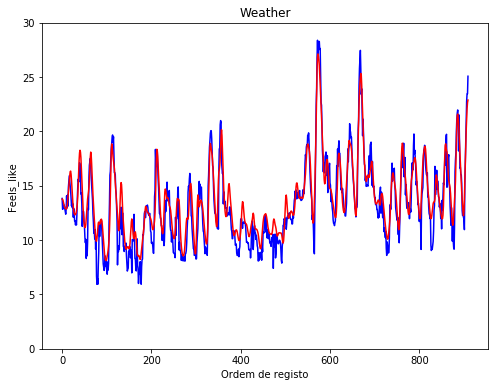

In [110]:
def plotWeatherDataset(data, predictions):
    plt.figure(figsize=(8, 6))
    plt.plot(range(len(data)), data, color='blue', label='Registed Values')
    plt.plot(range(len(predictions)), predictions, color='red', label='Prediction')
    plt.title('Weather')
    plt.ylim(0,30) 
    plt.ylabel('Feels_like')
    plt.xlabel('Ordem de registo')
    plt.show()
    
plotWeatherDataset(registed, predictions)


In [111]:
trainScore = math.sqrt(mean_squared_error(registed, predictions))
print('Train Score: %.2f RMSE' % (trainScore))
trainScore = mean_absolute_error(registed, predictions)
print('Train Score: %.2f MAE' % (trainScore))

Train Score: 1.47 RMSE
Train Score: 1.14 MAE


#### Plot predicted humidity (validated against train data)

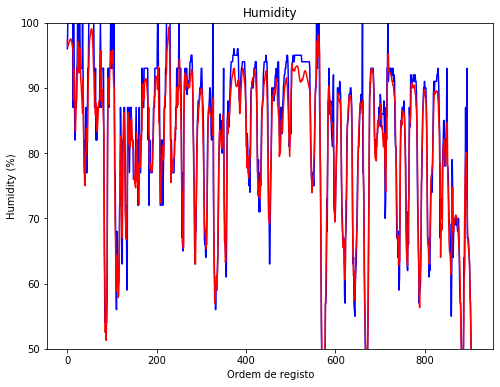

In [112]:
def plotHumidityDataset(data, predictions):
    plt.figure(figsize=(8, 6))
    plt.plot(range(len(data)), data, color='blue', label='Registed Values')
    plt.plot(range(len(predictions)), predictions, color='red', label='Predicted Values')
    plt.title('Humidity')
    plt.ylim(50,100) 
    plt.ylabel('Humidity (%)')
    plt.xlabel('Ordem de registo')
    plt.show()
    
plotHumidityDataset(registed_h, predictions_h)

In [113]:
trainScore = math.sqrt(mean_squared_error(registed_h, predictions_h))
print('Train Score: %.2f RMSE' % (trainScore))
trainScore = mean_absolute_error(registed_h, predictions_h)
print('Train Score: %.2f MAE' % (trainScore))

Train Score: 3.62 RMSE
Train Score: 2.69 MAE


#### Plot predicted UV level (validated against train data)

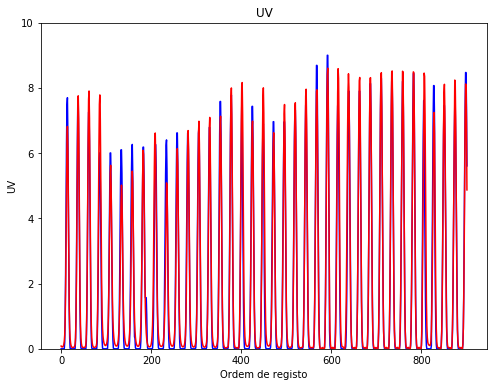

In [114]:
def plotUvDataset(data, predictions):
    plt.figure(figsize=(8, 6))
    plt.plot(range(len(data)), data, color='blue', label='Registed Values')
    plt.plot(range(len(predictions)), predictions, color='red', label='Predicted Values')
    plt.title('UV')
    plt.ylim(0,10) 
    plt.ylabel('UV')
    plt.xlabel('Ordem de registo')
    plt.show()
    
plotUvDataset(registed_u, predictions_u)

In [115]:
trainScore = math.sqrt(mean_squared_error(registed_u, predictions_u))
print('Train Score: %.2f RMSE' % (trainScore))
trainScore = mean_absolute_error(registed_u, predictions_u)
print('Train Score: %.2f MAE' % (trainScore))

Train Score: 0.54 RMSE
Train Score: 0.31 MAE


## Evaluate predictions

In [116]:
targetWeather, targetHumidity = prepare_data(dataWM[240:264])
targetUV = prepare_uv_data(dataUV[240:264])

inputUv = prepare_uv_data(dataUV[72:240])
inputWeather, inputHumidity = prepare_data(dataWM[72:240])

scaler_w, inputWeather = normalize_weather_data(inputWeather)
scaler_h, inputHumidity = normalize_humidity_data(inputHumidity)
scaler_u, inputUv = normalize_uv_data(inputUv)


def forecast(model, df, timesteps, multisteps, scaler):
    input_seq = df[-timesteps:]
    inp = input_seq
    predictions = list()
    
    for step in range(1, multisteps+1):
        inp = inp.reshape(1, timesteps, 1)
        yhat = model.predict(inp, verbose=1)
        yhat_inversed = scaler.inverse_transform(yhat)
        predictions.append(yhat_inversed[0][0])
        inp = np.append(inp[0], yhat)
        inp = inp[-timesteps:]
    return predictions


1/1 [==============================] - 0s 103ms/sample


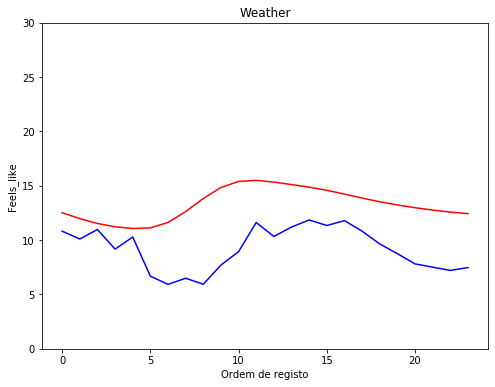

In [117]:
predictions_w = forecast(model, inputWeather, 168, 24, scaler_w)
plotWeatherDataset(targetWeather, predictions_w)

1/1 [==============================] - 0s 134ms/sample


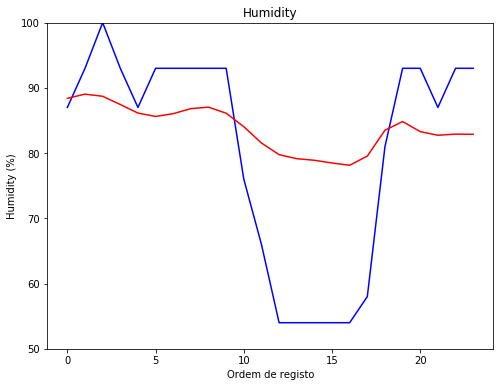

In [118]:
predictions_h = forecast(model_h, inputHumidity, 168, 24, scaler_h)
plotHumidityDataset(targetHumidity, predictions_h)

1/1 [==============================] - 0s 106ms/sample


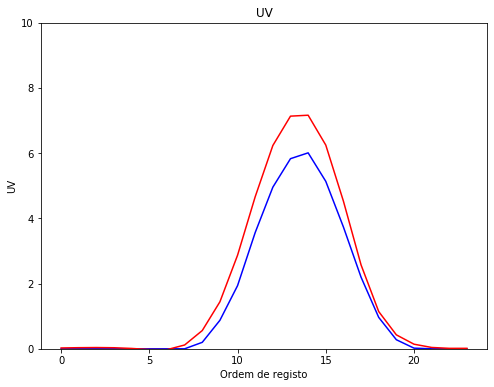

In [119]:
predictions_u = forecast(model_u, inputUv, 168, 24, scaler_u)
plotUvDataset(targetUV, predictions_u)

## Forecast

In [120]:
multistep = 24

def forecast(model, df, timesteps, multisteps, scaler):
    input_seq = df[-timesteps:]
    inp = input_seq
    predictions = list()
    
    for step in range(1, multisteps+1):
        inp = inp.reshape(1, timesteps, 1)
        yhat = model.predict(inp, verbose=1)
        yhat_inversed = scaler.inverse_transform(yhat)
        predictions.append(yhat_inversed[0][0])
        inp = np.append(inp[0], yhat)
        inp = inp[-timesteps:]
    return predictions


#### Plot weather forecasted for next 24 h

1/1 [==============================] - 0s 123ms/sample


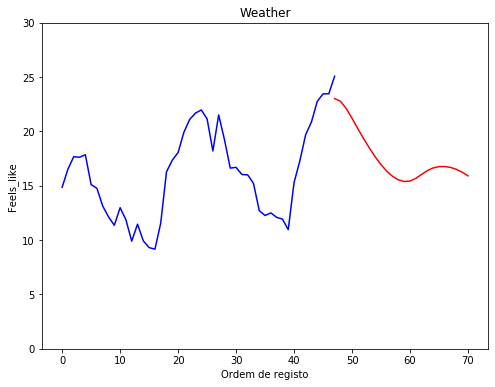

In [121]:
predictionsWeatherNext24 = forecast(model, df, timesteps, multistep, scaler)

def plotForecastedWeather(data, predictions):
    plt.figure(figsize=(8, 6))
    plt.plot(range(len(data)), data, color='blue', label='Registed Values')
    plt.plot(range(len(data)-1, len(data)+len(predictions)-1), predictions, color='red', label='Prediction')
    plt.title('Weather')
    plt.ylim(0,30) 
    plt.ylabel('Feels_like')
    plt.xlabel('Ordem de registo')
    plt.show()


data, _ = prepare_data(dataWM)
last_48h = data[-48:]
plotForecastedWeather(last_48h, predictionsWeatherNext24)

#### Plot humidity forecasted for next 24 h

1/1 [==============================] - 0s 121ms/sample


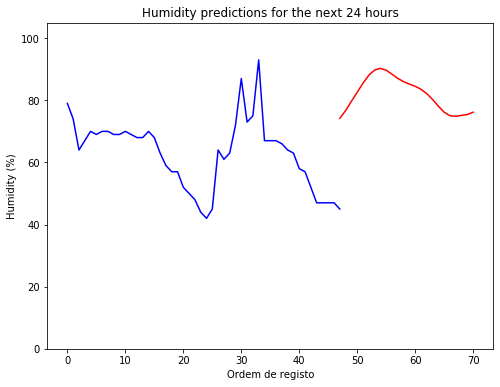

In [122]:
predictionsHumidityNext24 = forecast(model_h, df_h, timesteps, multistep, scaler_h)

def plotForecastedWeather(data, predictions):
    plt.figure(figsize=(8, 6))
    plt.plot(range(len(data)), data, color='blue', label='Registed Values')
    plt.plot(range(len(data)-1, len(data)+len(predictions)-1), predictions, color='red', label='Prediction')
    plt.title('Humidity predictions for the next 24 hours')
    plt.ylim(0,105) 
    plt.ylabel('Humidity (%)')
    plt.xlabel('Ordem de registo')
    plt.show()


_, data = prepare_data(dataWM)
last_48h = data[-48:]
plotForecastedWeather(last_48h, predictionsHumidityNext24)

#### Plot UV forecasted for next 24 h

1/1 [==============================] - 0s 87ms/sample


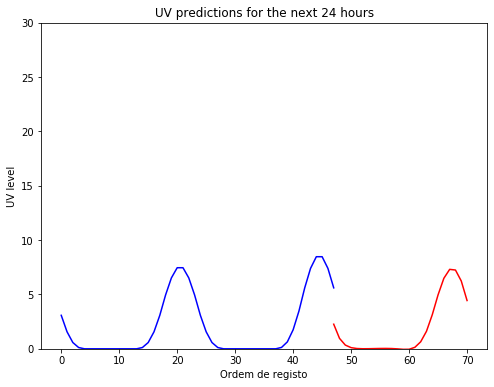

In [123]:
predictionsUVNext24 = forecast(model_u, df_u, timesteps, multistep, scaler_u)

def plotForecastedWeather(data, predictions):
    plt.figure(figsize=(8, 6))
    plt.plot(range(len(data)), data, color='blue', label='Registed Values')
    plt.plot(range(len(data)-1, len(data)+len(predictions)-1), predictions, color='red', label='Prediction')
    plt.title('UV predictions for the next 24 hours')
    plt.ylim(0,30) 
    plt.ylabel('UV level')
    plt.xlabel('Ordem de registo')
    plt.show()


data = prepare_uv_data(dataUV)
last_48h = data[-48:]
plotForecastedWeather(last_48h, predictionsUVNext24)

## Classifying the predictions

In [76]:
def weather_classifier(temp, humidity, uv):
    labels = []

    for i in range(24):
        score = 0
        
        if(temp[i] >= 15 and temp[i] <= 20):
            score = score + 3
        elif(temp[i] >= 10 and temp[i] <= 15):
            score = score + 2
        elif(temp[i] < 10 or temp[i] > 20):
            score = score - 1
        elif(temp[i] < 5 or temp[i] > 25):
            score = score - 2
        
        if(humidity[i] < 50):
            score = score + 1
        elif(humidity[i] > 80):
            score = score - 2

        if(uv[i] <= 3.0):
            score = score + 2
        elif(uv[i] <= 5.9):
            score = score + 1
        elif(uv[i] >= 8.0):
            score = score - 1
        
        if(score >= 4):
            labels.append(3)
        elif(score < 4 and score >= 3):
            labels.append(2)
        elif(score < 3):
            labels.append(1)
    
    return labels

scores = weather_classifier(predictionsWeatherNext24, predictionsHumidityNext24, predictionsUVNext24)
scores

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 1, 2, 2, 2, 2, 1]

## Aggregate results

In [77]:
import pytz
from datetime import datetime


last_hour = round(dataWM.iloc[-1:,5])

hours = []
for i in range(1,25):
    hours.append((last_hour + i) % 24)


data = {
    u'hours': list(map(float, hours)),
    u'weather_predictions': list(map(float,predictionsWeatherNext24)),
    u'humidity_predictions': list(map(float,predictionsHumidityNext24)),
    u'uv_predictions': list(map(float,predictionsUVNext24)),
    u'scores': list(map(float,scores))
}



date_time = datetime.now()

db.collection(u'Predictions').document(f'{date_time}').set(data)    



update_time {
  seconds: 1589740732
  nanos: 205463000
}